# Fine tuning classification example

We will fine-tune an ada classifier to distinguish between the two sports: Baseball and Hockey.

 ## Data exploration
 The newsgroup dataset can be loaded using sklearn. First we will look at the data itself:

One sample from the baseball category can be seen above. It is an email to a mailing list. We can observe that we have 1197 examples in total, which are evenly split between the two sports.

## Data Preparation
We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [51]:
import os
import pandas as pd

# initialize an empty dataframe
df = pd.DataFrame(columns=['prompt', 'completion'])

# specify the root directory containing your folders
root_dir = '../final_dataset1'

# loop through each folder in the directory
for folder in os.listdir(root_dir):
    # construct the path to each file
    instructions_path = os.path.join(root_dir, folder, 'instruction.txt')
    responses_path = os.path.join(root_dir, folder, 'response.txt')
    dom_path = os.path.join(root_dir, folder, 'DOM.txt')

    # make sure all files exist
    if os.path.exists(instructions_path) and os.path.exists(responses_path) and os.path.exists(dom_path):
        # read the DOM file
        try:
            with open(dom_path, 'r') as f:
                dom = f.read().strip()
        except:
            with open(dom_path, 'r', encoding='ISO-8859-1') as f:
                dom = f.read().strip()
        # read the instructions and responses files, line by line
        with open(instructions_path, 'r') as f1, open(responses_path, 'r') as f2:
            for instruction, response in zip(f1, f2):
                # create the prompt
                prompt = instruction.strip() + "[SEP]" + dom
                # get the response
                completion = response.strip()

                # append the new row to the dataframe
                df = pd.concat([df, pd.DataFrame([{'prompt': prompt, 'completion': completion}])], ignore_index=True)
df.head()

,prompt,completion
0,Open Text only email template[SEP]Title : Conv...,13
1,Edit Text only email template[SEP]Title : Conv...,13
2,I want to create a new email campaign[SEP]Titl...,11
3,"Help me create a campaign[SEP]Title : Manage, ...",11
4,Can you guide me through the process of select...,14


Both baseball and hockey are single tokens. We save the dataset as a jsonl file.

In [50]:
import os

# specify the root directory containing your folders
root_dir = '../final_dataset1'

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename == "instructions.txt":
            old_file_path = os.path.join(dirpath, filename)
            new_file_path = os.path.join(dirpath, "instruction.txt")
            os.rename(old_file_path, new_file_path)

print("Renaming completed.")


Renaming completed.


In [52]:
df.to_json("final_dataset1.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [27]:
!pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [53]:
!openai tools fine_tunes.prepare_data -f final_dataset1.jsonl -q

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Analyzing...

- Your file contains 1198 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 7 duplicated prompt-completion sets. These are rows: [930, 949, 950, 955, 956, 957, 958]
- Your data does no

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

In [7]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [1]:
import openai

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
openai.api_key = os.getenv('OPENAI_API_KEY')

In [8]:
!openai api fine_tunes.create -t "final_dataset1_prepared_train.jsonl" -v "final_dataset1_prepared_valid.jsonl" -m ada

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Error: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your API key is stored in a file, you can point the openai module at it with 'openai.api_key_path = <PATH>'. You can generate API keys in the OpenAI web interface. See https://platform.openai.com/account/api-keys for details.


The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [32]:
!openai api fine_tunes.results -i ft-2zaA7qi0rxJduWQpdvOvmGn3 > result.csv

Error: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your API key is stored in a file, you can point the openai module at it with 'openai.api_key_path = <PATH>'. You can generate API keys in the OpenAI web interface. See https://platform.openai.com/account/api-keys for details.


In [33]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

KeyError: 'classification/accuracy'

The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run. 

<AxesSubplot:>

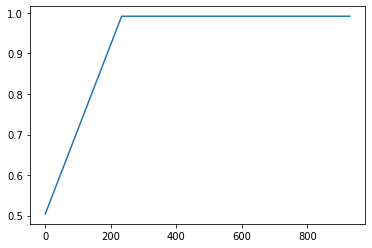

In [ ]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

In [9]:
import pandas as pd
import openai
from dotenv import load_dotenv
import os
load_dotenv()

True

In [3]:
train = pd.read_json('final_dataset1_prepared_train.jsonl', lines=True)

In [4]:
test = pd.read_json('final_dataset1_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,Edit Text only email template[SEP]Title : Conv...,13
1,I want to design my own email template[SEP]Tit...,23
2,Can I track the performance of my email campai...,15
3,"I want to track my emails[SEP]Title : Manage, ...",15
4,Where can I find the list of email templates[S...,12


We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [10]:
openai.api_key=os.getenv("OPENAI_API_KEY")

In [15]:
test['prompt'][3]

'I want to track my emails[SEP]Title : Manage, create and send your email campaigns\ndiv : Your free trial expires in\xa030 days\ndiv : 30 days\ndiv : Upgrade now\ndiv : close\nlabel : Owner\nlabel : Taimoor Sardar\ndiv : expand_more\ndiv : home\ndiv : add\nspan : Campaigns\ndiv : expand_more\nspan : Growth Tools\nspan : Audience\nspan : Reports\ndiv : Automation\ndiv : 0 out of 1,000\xa0members\ndiv : expand_more\ndiv : search\ninput : No Type : No Name\ndiv : All\ndiv : All\ndiv : keyboard_arrow_down\ndiv : help\ndiv : person\ndiv : expand_more\ndiv : Welcome\ndiv : Let\x92s help you get started!\ndiv : 1\ndiv : Create your first email list\ndiv : 2\ndiv : Import your subscribers\ndiv : 3\ndiv : Set up your first \x93from\x94 name\ndiv : 4\ndiv : Create your first campaign\nlabel : STEP 1 OF 4\nlabel : Create your first email list\ndiv : Email lists allow you to store and manage all your subscribers\x92 data that you can later use for personalizing your emails.\ndiv : It\x92s a criti

In [16]:
test['completion'][3]

15

In [13]:
ft_model = 'ada:ft-personal-2023-06-27-06-24-04'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][3], max_tokens=1, temperature=0)
res['choices'][0]['text']


' 11'

In [30]:
ft_model = 'ada:ft-personal-2023-06-27-06-24-04'
correct = 0
dir_path = "./errors/"

if not os.path.exists(dir_path):
        os.makedirs(dir_path)

for i, text in enumerate(test['prompt'][:3]):
        
        res = openai.Completion.create(model=ft_model, prompt=test['prompt'][i], max_tokens=1, temperature=0)

        target = test['completion'][i]
        prediction = int(res['choices'][0]['text'])

        if target == prediction: 
             correct += 1
             with open("./correc.txt", "a") as f:
                  f.write(f"{i+1}\n")
             print(f"i={i}")
             continue

        lines = text.split('\n')

        # Check if start_line and end_line are within the bounds of the lines array
        if target <= len(lines):
            lines[target-1] = '--------> ' + lines[target-1]
        if prediction <= len(lines):
            lines[prediction-1] = 'xxxxxxxx ' + lines[prediction-1]
        else:
             lines[len(lines)-1] = str(prediction) + " xxx " + lines[len(lines)-1]

        # Create a new file for each text
        filename = f"text_{i+1}.txt"
        with open(os.path.join(dir_path, filename), "w") as f:
            f.write('\n'.join(lines))

i=0


In [24]:
res['choices'][0]['text']

' 10'

In [47]:
itemNum = 1

In [48]:
print(train['prompt'][itemNum])
print(train["completion"][itemNum])


Can you provide instructions for using Databricks on Google Cloud[SEP]Title : Google Cloud Free Trial – Databricks
h1 : Try Databricks on Google Cloud for Free
div : Get Started with a Free 14-day Trial of Databricks on Google Cloud.
p : One open lakehouse platform to store and manage all of your data for data engineering, data science, and analytics.
p : What you get:
li : Databricks account on Google Cloud
li : Single Sign-on into Databricks with Google Cloud Identity
li : Single-click cluster set up running on Google Kubernetes Engine (GKE), processing data in your own account
li : Built-in integration with Google Cloud Storage, Big Query, Pub/Sub and Looker
li : Ability to run production ELT/ETL pipelines at massive scale
li : Fully collaborative notebooks with multi-language support
li : Out-of-the-box native support for ML frameworks like MLflow, scikit-learn, TensorFlow and Keras
h2 : Please tell us about yourself
div : *
label : *First Name:
input : text : FirstName
label : *La

In [49]:
ft_model = 'ada:ft-personal-2023-06-26-06-15-06'
res = openai.Completion.create(model=ft_model, prompt=train['prompt'][itemNum] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']

InvalidRequestError: This model's maximum context length is 2049 tokens, however you requested 2412 tokens (2411 in your prompt; 1 for the completion). Please reduce your prompt; or completion length.

To get the log probabilities, we can specify logprobs parameter on the completion request

In [15]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7fe114e435c8> JSON: {
  " baseball": -7.6311407,
  " hockey": -0.0006307676
}

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.

### Generalization
Interestingly, our fine-tuned classifier is quite versatile. Despite being trained on emails to different mailing lists, it also successfully predicts tweets.

In [16]:
sample_hockey_tweet = """Thank you to the 
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the 
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [17]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'